In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pickle import dump, load

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils.class_weight import compute_class_weight

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

In [10]:
tweets_df = pd.read_csv("data/cyberbullying_tweets.csv")
tweets_df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [11]:
def convertToBullyClassification(cyberbullying_type):
    return cyberbullying_type != "not_cyberbullying"

In [12]:
tweets_df["cyberbullying_type"] = tweets_df["cyberbullying_type"].apply(convertToBullyClassification)
tweets_df.rename(columns={"cyberbullying_type":"is_cyberbullying"})
tweets_df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",False
1,Why is #aussietv so white? #MKR #theblock #ImA...,False
2,@XochitlSuckkks a classy whore? Or more red ve...,False
3,"@Jason_Gio meh. :P thanks for the heads up, b...",False
4,@RudhoeEnglish This is an ISIS account pretend...,False
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",True
47688,Turner did not withhold his disappointment. Tu...,True
47689,I swear to God. This dumb nigger bitch. I have...,True
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,True


In [13]:
print(tweets_df['cyberbullying_type'].value_counts().get(True, 0))
print(tweets_df['cyberbullying_type'].value_counts().get(False, 0))

39747
7945


In [15]:
# Data splitting
text_features = "tweet_text"
target_feature = "cyberbullying_type"
data = tweets_df

train_data, test_data = train_test_split(data, test_size=0.2, random_state=123)

X_train = train_data.drop(columns=target_feature)
y_train = train_data["cyberbullying_type"]

X_test = test_data.drop(columns=target_feature)
y_test = test_data["cyberbullying_type"]

### Text Processing
Define TF-IDF to pre-process the text data into vector representations

In [7]:
# TF-IDF definition
TFIDF = TfidfVectorizer(lowercase = False)

### Model Definition
Defining transformers for text pre-processing and model pipelines

In [8]:
# TF-IDF pre-processor transformer
TFIDF_preprocessor = ColumnTransformer(
    transformers=[
        ('text', TFIDF, text_features)
    ],
    remainder='passthrough'
)

In [9]:
# Model pipelines

# LinearSVM + TF-IDF pipeline
linear_svm_tfidf = Pipeline(
    steps = [
        ("transformer", TFIDF_preprocessor),
        ("linearsvm", LinearSVC(random_state=123, class_weight='balanced'))
    ]
)

In [10]:
# LR + TF-IDF pipeline
lr_tfidf = Pipeline(
    steps = [
        ("transformer", TFIDF_preprocessor),
        ("lr", LogisticRegression(random_state=123,class_weight='balanced'))
    ]
)

### Hyperparameter Settings
Hyperparameters for Logistic Regression (LR) and LinearSVM classification models

In [11]:
CV = 5

svm_param_grid = {
    'svm__C': [1, 10, 100, 1000],
    'svm__gamma': [1, 0.1, 0.001, 0.0001],
    'svm__kernel': ['linear', 'rbf', 'poly'],
}

linear_svm_param_grid = {
    'linearsvm__C': [0.001, 0.01, 1, 10, 100],
    'linearsvm__max_iter': [10000, 20000, 50000],
    'linearsvm__tol': [1e-2, 1e-4, 1e-6],
}

lr_param_grid = {
    'lr__C': [0.1, 1, 10, 100],
    'lr__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'lr__max_iter': [250, 500, 1000],
    'lr__fit_intercept': [True, False],
    'lr__solver': ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg']
}

### LinearSVM Hyperparameter Tuning
Hyperparameter tuning using GridSearchCV for `linear_svm_tfidf`

In [ ]:
linear_svm_tfidf_grid = GridSearchCV(linear_svm_tfidf, linear_svm_param_grid, cv=CV, n_jobs=-1, verbose=2)
linear_svm_tfidf_grid.fit(X_train, y_train)
linear_svm_tfidf_results = pd.DataFrame(linear_svm_tfidf_grid.cv_results_)
linear_svm_tfidf_results.to_csv('linear_svm_tfidf_results.csv', index=False)

sorted_linear_svm_tfidf_results = linear_svm_tfidf_results.sort_values(by=["rank_test_score", "mean_fit_time"], ascending=[True, True])
linear_svm_tfidf_best_params = sorted_linear_svm_tfidf_results.iloc[0]["params"]
print(f"Best Params: {linear_svm_tfidf_best_params}")

### Logistic Regression (LR) Hyperparameter Tuning
Hyperparameter tuning using GridSearchCV for `lr_tfidf`

In [ ]:
lr_tfidf_grid = GridSearchCV(lr_tfidf, lr_param_grid, cv=CV, n_jobs=-1, verbose=2)
lr_tfidf_grid.fit(X_train, y_train)
lr_tfidf_results = pd.DataFrame(lr_tfidf_grid.cv_results_)
lr_tfidf_results.to_csv('lr_tfidf_results.csv', index=False)

sorted_lr_tfidf_results = lr_tfidf_results.sort_values(by=["rank_test_score", "mean_fit_time"], ascending=[True, True])
lr_tfidf_best_params = sorted_lr_tfidf_results.iloc[0]["params"]
print(f"Best Params: {lr_tfidf_best_params}")

### Best Models
Best parameters for the LinearSVM and LR models

In [14]:
# Best LinearSVM
linear_svm_tfidf.set_params(**linear_svm_tfidf_best_params)
linear_svm_tfidf.fit(X_train, y_train)
print("svm fitted!")

svm fitted!


In [15]:
# Best LR
lr_tfidf.set_params(**lr_tfidf_best_params)
lr_tfidf.fit(X_train, y_train)
print("lr fitted!")

lr fitted!


### Save Model

In [ ]:
with open("linear_svm.pkl", "wb") as f:
    dump(linear_svm_tfidf, f, protocol=5)

In [17]:
with open("lr.pkl", "wb") as f:
    dump(lr_tfidf, f, protocol=5)

### Load Model

In [7]:
with open("linear_svm.pkl", "rb") as f:
    linear_svm_tfidf = load(f)

In [4]:
with open("lr.pkl", "rb") as f:
    lr_tfidf = load(f)

In [22]:
example = pd.DataFrame({'tweet_text': ["hey man"]})
lr_tfidf.predict(X_test)

array([ True,  True,  True, ...,  True,  True,  True])

### Confusion Matrices and Scores

Confusion matrix plots and metric scores for all models

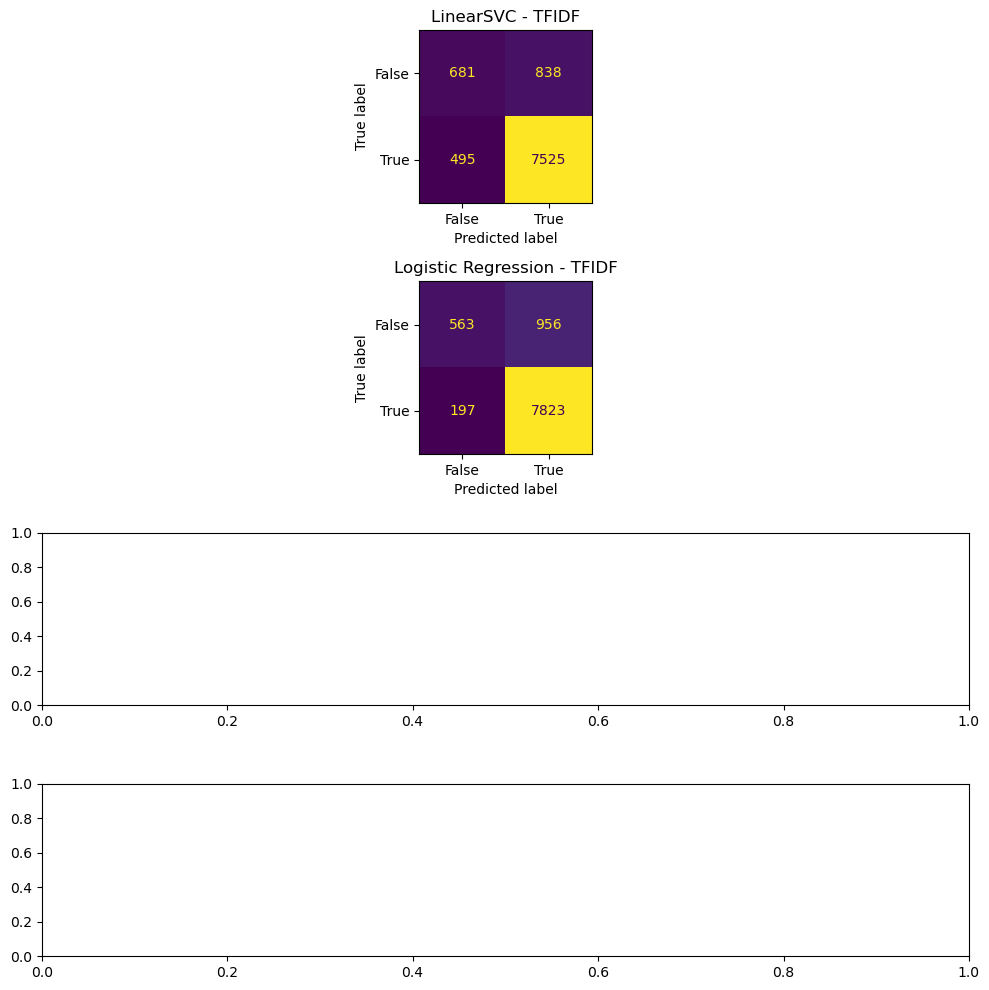

,Accuracy,Precision,Recall,F1-Score
LinearSVC - TFIDF,0.860258,0.579082,0.448321,0.505380
Logistic Regression - TFIDF,0.879128,0.740789,0.370639,0.494076


In [16]:
# Best Models
models = [linear_svm_tfidf, lr_tfidf]

# Model Names
model_names = [
    "LinearSVC - TFIDF",
    "Logistic Regression - TFIDF"
]

# Scores
scores = {}

fig, axes = plt.subplots(4, 1, figsize=(10, 10))

for ax, model, name in zip(axes, models, model_names):
  ax.set_title(name)

  matrix = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax, colorbar=False)

  arr = matrix.confusion_matrix

  TP = arr[0, 0]
  FP = arr[1, 0]
  FN = arr[0, 1]
  TN = arr[1, 1]

  scores[name] = {}

  scores[name]["Accuracy"] = (TP + TN) / arr.sum()
  scores[name]["Precision"] = TP / (TP + FP)
  scores[name]["Recall"] = TP / (TP + FN)
  scores[name]["F1-Score"] = 2 * (scores[name]["Precision"] * scores[name]["Recall"]) / (scores[name]["Precision"] + scores[name]["Recall"])

plt.tight_layout()
plt.show()
display(pd.DataFrame(scores).T)